### Apply the model

##### libraries

In [151]:
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn

from sklearn import preprocessing, model_selection
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import rcParams
from matplotlib import pyplot
import plotly.express as px
rcParams['axes.titlepad'] = 10

In [152]:
df =pd.read_csv("aids.csv")
df.head()

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,1108,1,37,88.11364,0,1,1,100,0,1,...,1,1,0,0,0,389,320,734,737,1
1,1079,0,43,66.77075,0,0,0,100,0,1,...,0,2,0,1,1,318,432,912,1213,0
2,492,1,34,82.91725,0,0,0,90,0,1,...,1,2,0,1,1,326,524,660,835,0
3,1191,1,41,98.91817,0,0,0,81,0,1,...,1,3,0,1,0,318,232,1131,982,1
4,1141,3,47,53.61717,0,1,0,100,0,0,...,0,1,0,1,0,280,337,515,679,0


#### K-fold cross validation to find the best hyperparameters
##### parameters are internal settings learned during training by the XGBoost algorithm itself, whereas hyperparameters are external settings that the user defines and adjusts to optimize the model's performance

In [156]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

X = df.drop('infected', axis=1)  
y = df['infected'].astype(int)  # Assicurati che y sia di tipo int (binario)
#X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

print(X.head())
print(round(len(y_train[y_train==1])/len(y_train),2))
print(round(len(y_test[y_test==1])/len(y_test),2))
print(len(y_train==0)/len(y_train[y_train==1]))

   time  trt  age      wtkg  hemo  homo  drugs  karnof  oprior  z30  ...  \
0  1108    1   37  88.11364     0     1      1     100       0    1  ...   
1  1079    0   43  66.77075     0     0      0     100       0    1  ...   
2   492    1   34  82.91725     0     0      0      90       0    1  ...   
3  1191    1   41  98.91817     0     0      0      81       0    1  ...   
4  1141    3   47  53.61717     0     1      0     100       0    0  ...   

   gender  str2  strat  symptom  treat  offtrt  cd40  cd420  cd80  cd820  
0       0     1      1        0      0       0   389    320   734    737  
1       1     0      2        0      1       1   318    432   912   1213  
2       1     1      2        0      1       1   326    524   660    835  
3       1     1      3        0      1       0   318    232  1131    982  
4       1     0      1        0      1       0   280    337   515    679  

[5 rows x 22 columns]
0.31
0.31
3.2287822878228782


#### Hyperparameters tuning

In [157]:
opt_parameters = {
    'n_estimators': [100, 200, 300, 350, 400, 450, 500],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [3, 5, 7, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1, 5, 10],
    'reg_lambda': [0, 0.1, 0.5, 1, 5, 10],
    'scale_pos_weight': [1, 1.5, 2, 2.5, 3, 3.22, 3.5, 4]
}

rand_search = RandomizedSearchCV(XGBClassifier(), param_distributions=opt_parameters, n_iter=30, scoring='recall', cv=10, verbose=0, random_state=96)
rand_search.fit(X_train, y_train)

best_params = rand_search.best_params_
print("Migliori Parametri:", best_params)

Migliori Parametri: {'subsample': 0.7, 'scale_pos_weight': 3, 'reg_lambda': 5, 'reg_alpha': 10, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 1.0}


#### The model

XGBoost model recall score: 0.7687
XGBoost model accuracy score: 0.5762


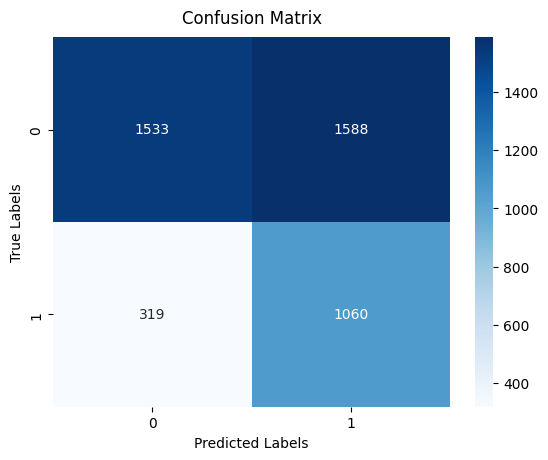

In [158]:
xgb_clf_best = XGBClassifier(**best_params)
xgb_clf_best.fit(X_train, y_train)

# Predizctions on  test set
y_pred = xgb_clf_best.predict(X_test)

recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print('XGBoost model recall score: {0:0.4f}'.format(recall))
print('XGBoost model accuracy score: {0:0.4f}'.format(accuracy))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
